# Analysis and visualisation of loudness transformation functions

## Setup

In [2]:
# -*- coding: utf-8 -*-
import sys
import os
# Build a path from the notebook's parent directory to the python modules
module_path = os.path.abspath(os.path.join('..'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)

# import statements
import numpy as np
import pandas as pd
from PyQt5.QtWidgets import QFileDialog, QApplication
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pingouin as pg
from cycler import cycler

In [3]:
# set plot parameters
sns.set_style('white')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE,
       labelsize=MEDIUM_SIZE)    # fontsize of the axes title and x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mycolours = [(0, 102, 255), (0, 204, 153), (255, 0, 102), (74, 111, 152),
             (251, 164, 49), (204, 153, 255), (90, 192, 255), (80, 245, 233),
             (255, 90, 192), (164, 201, 242), (255, 254, 139), (255, 243, 255)]
mycolours = [tuple(shade/255 for shade in colour) for colour in mycolours]

# enable copy-on-write mode for Pandas (will be default from Pandas 3.0)
pd.options.mode.copy_on_write = True

# check/open QApplication instance
if not QApplication.instance():
    app = QApplication(sys.argv)
else:
    app = QApplication.instance() 

# set numpy seed
np.random.seed(808)


Set the saveplots toggle to True if plot saving is desired:

In [33]:
saveplots = True

if saveplots:
    # select figure output save path
    outFigPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save plots '05 Impact\Conferences\AIAA_2026'")

    # create subfolders if not already existing
    try:
        os.mkdir(os.path.join(outFigPath, "svg"))
    except FileExistsError:
        pass

    try:
        os.mkdir(os.path.join(outFigPath, "pdf"))
    except FileExistsError:
        pass


Define the phons array used in Table 5 of ISO 532-3:2023.

In [5]:
phons = np.array([2.2, 4, 5, 7.5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120])

levelTQ1kHz = 3  # level in dB of threshold in quiet for critical band corresponding with 1 kHz 1/3-octave band

Data obtained from Sottek Hearing Model loudness for phons (1 kHz sine).

In [6]:
data_Sottek_phon2sone = np.array([0.019458521, 0.028430818, 0.033977327, 0.050574193, 0.071714373, 0.137486033, 0.234276606, 0.366260639, 0.532778404,
                                  0.740426759, 1.000038026, 1.326659512, 1.723492431, 2.202860981, 2.792292998, 3.532137064, 4.498718178, 5.751951986,
                                  7.39280345, 9.540658218, 12.36259442, 16.13014782, 21.2805, 28.45957385, 38.54673951, 52.78091726, 73.02860315])

Calculated loudness using ISO 532-1 Zwicker model (Equation A.2 --- note that the exp(0.9845425) term is required to correct the core loudness transform to 1 sone at 40 phon)

In [11]:
calc_Zwicker_phon2sone = 0.0635*(10**(levelTQ1kHz/10))**0.25*((1 - 0.25 + 0.25*10**((phons - levelTQ1kHz)/10))**0.25 - 1)*np.exp(0.9845425)
calc_Zwicker_phon2sone[calc_Zwicker_phon2sone < 0] = 0  # set negative values to zero

Calculated loudness using alternative transform function obtained using non-linear optimisation.

In [12]:
def calc_ZwickerSottek_transform(excitation):
    q2 = 1.5016
    q3 = 0.2552
    q4 = 0.20627
    q5 = -0.01067
    q6 = 108.66
    q7 = -17.03

    q0 = q2*np.exp(-q3*excitation) + q4 + q5*np.tanh((excitation - q6)/q7)

    return q0

q0 = calc_ZwickerSottek_transform(phons)
q1 = 0.1028045
calc_ZwickerSottek_phon2sone = q1*(10**(3/10))**q0*((1 - 0.25 + 0.25*10**((phons - 3)/10))**q0 - 1)*np.exp(0.9845425)
calc_ZwickerSottek_phon2sone[calc_ZwickerSottek_phon2sone < 0] = 0  # set negative values to zero

Plot the resulting curves

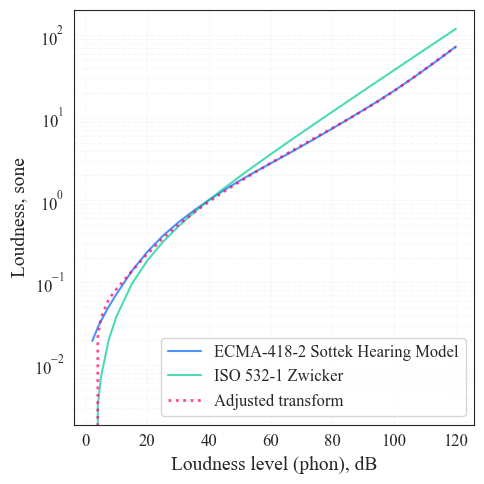

In [34]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.semilogy(phons, data_Sottek_phon2sone, color=mycolours[0], label='ECMA-418-2 Sottek Hearing Model', alpha=0.7)
ax.semilogy(phons, calc_Zwicker_phon2sone, color=mycolours[1], label='ISO 532-1 Zwicker', alpha=0.7)
ax.semilogy(phons, calc_ZwickerSottek_phon2sone, color=mycolours[2], label='Adjusted transform', markersize=0, alpha=0.7, linestyle=':', linewidth=2)
ax.set(xlabel="Loudness level (phon), dB", ylabel="Loudness, sone")
ax.grid(alpha=0.15, linestyle='--', which='both')
ax.legend(loc='lower right')

if saveplots:

    filename = "loudnessTransformComparison"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()